# Apply AI Superresolution to video - Train New Network from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places - complete
- different blur levels- complete
- different blur levels in the same image - complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop - use center crop
- crop to the super8 resolution 720x480 or video 320x240 - complete
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam - complete
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution - does not seem to help in convergence

## losses
- try l1 loss - does not converge
- try perceptive loss vgg18 - complete
- perceptive loss uses 256x256 images - too low res, so use overlapping subsets of image to calc loss
- combine perceptive and mse loss
- calculate mse loss on a smoothed version of output compared to input (which is smoothed) - ensure reversal matches


## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation
- get very focused images and use as a validation and test set - prefer one thats published


## Results & Analysis
- Fixes - jpeg artifacts were fixed at one level 30 and slope at 0.01 in:
Superresolution train vdsr with multifuz
Superresolution train vdsr with perception loss multifuz

- mse only goes so far.  too strict
- Perceptual loss helps improve it, but input is 256x256 resolution so limited sharpness.
- Perceptual loss tiled (hires) causes too much causes artifacts
- multifuz improves results especially with perceptual loss, handles different fuzziness better

Next experiment
- training may not need to go as long - complete
- set kernel range from 1 to 20 - vs 4-20 need lower range too - complete
- combination of hi res perceptual and mse on smoothed versions of input.- complete
- give more emphasis to mse

Other ideas
- train on cleaner images div8K
- cascade 2 models.  Train first as usual.  Use it to preprocess input to train second model
- apply mix-up
- better model and apply to all 3 colors - tried, but no improvement.
- try vgg perception metric
- focus prediction


RCAN Results
- Uses lots of resources as scale of image increases
- Does not handle different scales well
- not meant for restoration - 
To try
- Apply pretrained model on a patch thats 48x48 then can judge if its worth making an approach to apply repeatedly to larger images.
- train vdsr with a convolutional upscaling up front, attention, residuals.

UNET results
- Some sharpening but not drastic.  Not better than VDSR
- Used 2x GPU mem than VDSR

To Try
- UNET or VDSR with MAXout nonlinear function.  Try different activation functions (mish,etc).
- consistency error measure like fastai superres
- provide input,target  pairs with no fuzziness in the training set.
- Train exclusively on very sharp  images (DIV2K)
- Predict focus as a segmentation in addition to enhancing
- have 3 channel inputs (RGB or ??) and then have 1 channel output
- provide frame-1,frame,frame+1 to predict frame
- opposite of bottleneck - input resolution -> high res -> input res blocks.
- combo of UNET and VDSR
- attention?
- combo of perception and mse measure
- add validation set
- sort dataset into hard cases and easy cases, making cases harder with time.  (train on easy cases first, then fine tune with harder cases)
- make the camera model version of the data loader
- use mse but give more error to perception
- try reflection padding







## Share results
- put out an example on youtube to allow comparison


# Project Documentation

In [1]:

from pathlib import Path
import os


project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"

model_name_base = "NEWCNN"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train New Network.ipynb


In [4]:
nb_path = Path(NOTEBOOK_FULL_PATH)
print(nb_path)

# Make result folder if it does not exist
result_path = Path(project_base, results_folder , nb_path.stem )
print(result_path)
os.makedirs(result_path, exist_ok=True)

/SSD_link/superres/Superresolution train New Network.ipynb
/media/SSD/superres/Results/Superresolution train New Network


In [5]:
model_out_path=Path(project_base)/model_folder
print(model_out_path)
os.makedirs(model_out_path, exist_ok=True)

/media/SSD/superres/checkpoint


In [6]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [7]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale,ToPILImage

import random
#from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel


#import sys
#sys.path.insert(0, '/media/SSD/superres/pytorch-vdsr/')

#from vdsr import Net

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [8]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers


torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [75]:
import fnmatch

In [76]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".bmp"])

def is_video_file(path, extensions = ("mp4",)):
    return path.lower().endswith(extensions)

def frame_sampler1(length, frame_sample_size):

    # calculate middle of video and take 'frame_sample_size' frames from middle
    middle = length // 2
    left_length = frame_sample_size//2
    right_length = frame_sample_size - left_length
    left = max(0,middle - left_length)
    right = min(length, middle + right_length)
          
    return list(range(left,right))



def frame_sampler2(length, frame_sample_size):
    return np.linspace(0, length, 3+min(frame_sample_size,length)).astype(int)[2:-1]


# Make this load still photos too, and have them added with frame = 0
def make_framelist(video_dir,frame_sample_size = 10, match_exp = "*.*"):
    instances = []
    for filename in listdir(video_dir):
        

        if fnmatch.fnmatch(filename, match_exp):
            filepath = os.path.join(video_dir,filename)
            #print(filename)

            if is_video_file(filepath):
                # open video file
                cap = cv2.VideoCapture(str(filepath))

                # get frame count
                length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

                cap.release()

                if frame_sample_size is not None:
                    samples = frame_sampler2(length, frame_sample_size)
                    # append fn and frame num to instances
                else:
                    samples = range(0,length)

                for frame in samples:
                    item = {"Filepath":filepath,"Type":"frame",  "Framenum":frame}
                    instances.append(item)

            elif is_image_file(filepath):
                # open image file
                img = cv2.imread(filepath)
                item = {"Filepath":filepath, "Type":"image"}
                instances.append(item)
            
    return instances
        

In [10]:
# get a list of all the data
instances = make_framelist("/media/SSD/superres/video_data/train_data",1)

In [78]:
instances

True

In [12]:
def load_frame(instance):
    
    path = instance["Filepath"]
    
    if instance["Type"] == "frame":
        
        frame = instance["Framenum"]
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, img = cap.read()
        if ret==0:
            print("Error with:",instance)
    elif instance["Type"] == "image":
        img = cv2.imread(path)
    # convert to PIL RGB
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return Image.fromarray(im_rgb)



In [13]:
def tophat2D(r):
    
    d=2*int(r)+1
    Y, X = np.ogrid[:d, :d]
    c=int(r)
    k = (np.sqrt((X-c)**2 +  (Y-c)**2) <= r)*1 
    
    return k/k.sum()

In [14]:
class RescaleCrop(object):


    def __init__(self, crop_size ,kernel_width):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_width = kernel_width
        

    
        

    def __call__(self, img):
        
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+self.kernel_width+1)
        h_wanted = int(self.crop_size[1]+self.kernel_width+1)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img = CenterCrop((v_wanted,h_wanted))(img) 

        
        return img

In [15]:

def cv_center_crop(img,output_size):
        if isinstance(output_size, numbers.Number):
            output_size = (int(output_size), int(output_size))
            
        
        image_height = img.shape[0]
        image_width = img.shape[1]
        
        crop_height, crop_width = output_size
        crop_top = max(0,int(round((image_height - crop_height) / 2.)))
        crop_left = max(0,int(round((image_width - crop_width) / 2.)))
        #print("input:",img.shape)
        #print("output:",output_size)
        #print("crop:",crop_top,crop_top+output_size[0],crop_left,crop_left+output_size[1])
        return img[crop_top:crop_top+output_size[0],crop_left:crop_left+output_size[1]]

In [16]:
def create_circular_mask(h, w, slope=0.01, center=None, radius=None, scale=1.0):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((scale*(X - center[0]))**2 + ((Y-center[1])/scale)**2)

    mask = np.minimum((np.maximum(dist_from_center-radius,0)*slope)**(0.5),1.0)
    return mask

In [17]:
def cv_disk_blur(img_cv, kernel_width):
    k = tophat2D(int(kernel_width)/2.0)
    return cv2.filter2D(img_cv, cv2.CV_32F, k)

In [18]:
def pil_disk_blur(img,kernel_width):
    img_cv = cv_disk_blur(np.array(img),kernel_width)
    img_cv = cv2.normalize(img_cv, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    return Image.fromarray(img_cv)

In [19]:
class Multifuz(object):


    def __init__(self, crop_size ,kernel_a, kernel_b, quality, slope, radius, scale, center):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_a = kernel_a
        self.kernel_b = kernel_b
        self.quality = quality.item()
        self.slope = slope
        self.radius = radius
        self.scale = scale
        self.center = center
        

    
        

    def __call__(self, img):
        
        img_cv = np.array(img)
        d = img_cv .shape
        dim = (d[1], d[0])
        height = d[0]
        width = d[1]
        color = len(d)-2
        
        
        #blur kernel A
        
        k = tophat2D(int(self.kernel_a)/2.0)
        img_cv_blurA = cv2.filter2D(img_cv, cv2.CV_32F, k)
        img_cv_blurA = cv_center_crop(img_cv_blurA,self.crop_size)
        
        #blur kernel B
        k = tophat2D(int(self.kernel_b)/2.0)
        img_cv_blurB = cv2.filter2D(img_cv, cv2.CV_32F, k)
        img_cv_blurB = cv_center_crop(img_cv_blurB,self.crop_size)
        
        #add them with a mask
        # Normalize the alpha mask to keep intensity between 0 and 1
        
        alpha = create_circular_mask(h=self.crop_size[0], w=self.crop_size[1], slope=self.slope,center=self.center,
                                     radius=self.radius, scale = self.scale)*1.0
        
        if color ==1:
            alpha=np.reshape(alpha, (self.crop_size[0],self.crop_size[1],-1))
            alpha=np.broadcast_to(alpha,[self.crop_size[0],self.crop_size[1],3])
        
        #alpha = alpha.astype(float)/255
        
        # Multiply the foreground with the alpha matte
        
        
        
        img_cv_blurA = cv2.multiply(img_cv_blurA, alpha, dtype=cv2.CV_32F )
        # Multiply the background with ( 1 - alpha )

        
        img_cv_blurB = cv2.multiply(img_cv_blurB, 1.0 - alpha, dtype=cv2.CV_32F)
        # Add the masked foreground and background.

        #img_cv = img_cv_blurA
        img_cv = cv2.add(img_cv_blurA, img_cv_blurB, dtype=cv2.CV_32F)
        
        img_cv = cv2.normalize(img_cv, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        
        
        
    
        #Center Crop
        #img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,self.quality])
        
        
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

(731, 491) (720, 480)


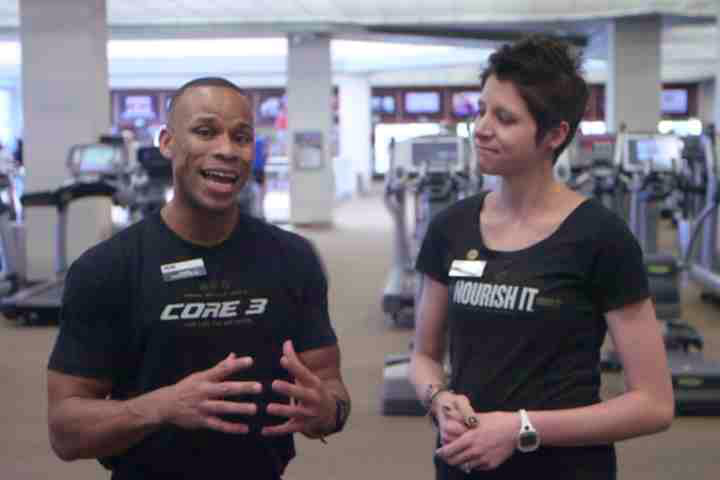

In [20]:
#test the Multifuz transform
im=load_frame(instances[10])
#im = Grayscale(num_output_channels=1)(im)
im = RescaleCrop(crop_size=(480,720),kernel_width=10)(im)
im_res = Multifuz(crop_size = (480,720),
                  center=(360,240),
                  kernel_a=2, 
                  kernel_b=10,
                  quality=np.int16(22), 
                  slope=.1,
                 radius=50,
                 scale=1)(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [79]:
class DatasetFromVideoFolder(data.Dataset):
    def __init__(self, video_dir,crop_size,frame_sample_size=10,max_kernel=10,Flip_hor=True,
                 Rand_bright_contrast=True, target_transform=None, match_exp="*.*", **camera_params):
        
        #  add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10

        super(DatasetFromVideoFolder, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size,match_exp)
        
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.crop_size = crop_size
        self.max_kernel = max_kernel
        self.target_transform = target_transform
        self.camera_params = camera_params
        self.input_transform = input_transform
        
    def camera_transform(self,img_hr):
        
        # go through the parameters and simulate the camera
        width, height = img_hr.size
               
        crop_top = max(0,int(round((height - self.crop_size[0]) / 2.)))
        crop_bottom = crop_top + self.crop_size[0]
        crop_left = max(0,int(round((width - self.crop_size[1]) / 2.)))
        crop_right = crop_left + self.crop_size[1]
        
        camera_specs = {}
        camera_specs["crop_size"] = np.int16(self.crop_size)
        
        camera_specs["center"] = np.int16((random.uniform(crop_left, crop_right),random.uniform(crop_top, crop_bottom)))
        
        camera_specs["scale"] = np.float32(random.uniform(0.5,2))
       
        
        camera_specs["kernel_a"] = np.float32(random.uniform(*self.camera_params["kernel_range"]))
        camera_specs["kernel_b"] = np.float32(random.uniform(*self.camera_params["kernel_range"]))
        camera_specs["quality"] = np.int16(random.uniform(*self.camera_params["quality_range"]))
        camera_specs["slope"] = np.float32(random.uniform(*self.camera_params["slope_range"]))
        camera_specs["radius"] = np.float32(random.uniform(*self.camera_params["radius_range"])*max(self.crop_size[0],self.crop_size[1]))
        
        img_lr = Multifuz(**camera_specs)(img_hr)
        return img_lr, camera_specs

    def __getitem__(self, index):
        img_hr = load_frame(self.video_frames[index])
        if self.crop_size is not None:
            img_hr = RescaleCrop(self.crop_size,self.max_kernel )(img_hr)
        
        if self.Flip_hor:
            img_hr = RandomHorizontalFlip()(img_hr)
        
        if self.Rand_bright_contrast:
            img_hr = ColorJitter(brightness=.2, contrast=.2)(img_hr)
        
        

        
        # go through the parameters and simulate the camera
        img_lr,camera_specs = self.camera_transform(img_hr)
            
        
        if self.input_transform:
            img_lr = self.input_transform()(img_lr)
        
        if self.target_transform:
            img_hr = self.target_transform(img_hr)
            
        #print(camera_specs)
        return img_lr, img_hr, camera_specs

    def __len__(self):
        return len(self.video_frames)

In [22]:
def input_transform():        
    return Compose([        
        Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])


In [23]:
train_dir = "/media/SSD/superres/video_data/train_data"
frame_sample_size =10
batch_size = 4 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
#crop_size = (256,256)
kernel_range=(1,10)
quality_range=(30,90) 
slope_range=(0.001, 0.1)
radius_range=(.05,.75)
scale_range=(1/2,2)
Flip_hor=True
Rand_bright_contrast=True

In [25]:
train_set = DatasetFromVideoFolder(train_dir,crop_size,frame_sample_size,
                                   input_transform=input_transform(),
                                   target_transform=target_transform(crop_size),
                                   Flip_hor=Flip_hor,
                                   Rand_bright_contrast=Rand_bright_contrast,
                                   kernel_range=kernel_range,
                                   quality_range=quality_range,
                                   slope_range=slope_range,
                                   radius_range=radius_range,
                                   scale_range=scale_range,
                                   max_kernel=10
                            )
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

In [100]:
valid_dir = "/home/filip/SSD_link/superres/video_data/test_data/BSD100_SR/image_SRF_4"
#frame_sample_size =10
#batch_size = 4 # Make 4 For FP16, 480x720 size images
#crop_size = (480,720)

kernel_range=(3,10)
quality_range=(30,90) 
slope_range=(0.001, 0.1)
radius_range=(.25,.75)
scale_range=(1/2,2)
Flip_hor=False
Rand_bright_contrast=False
match_exp = "*HR.png"

In [101]:
valid_set = DatasetFromVideoFolder(valid_dir,crop_size,frame_sample_size,
                                   input_transform=input_transform(),
                                   target_transform=target_transform(crop_size),
                                   Flip_hor=Flip_hor,
                                   Rand_bright_contrast=Rand_bright_contrast,
                                   kernel_range=kernel_range,
                                   quality_range=quality_range,
                                   slope_range=slope_range,
                                   radius_range=radius_range,
                                   scale_range=scale_range,
                                   max_kernel=10,
                                   match_exp=match_exp,
                            )
valid_data_loader = DataLoader(dataset=valid_set, num_workers=0, batch_size=batch_size, shuffle=False)

In [26]:
# measurement of blur of an image
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()


def show_batch(dataloader,size = 8):

    inputs, outputs, camera_specs = next(iter(dataloader))
    #print(inputs.shape)
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    outputs = outputs.numpy().transpose((0, 2, 3, 1))
    #print(camera_specs)
    
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = 2*size, 4*size
    fig=plt.figure(figsize=(w, h))
    columns = 2
    rows = 4
    ax=[]
    
    for i in range(0, rows):
        blur_measure_input = variance_of_laplacian((inputs[i]*255).astype(np.uint8))
        blur_measure_output = variance_of_laplacian((outputs[i]*255).astype(np.uint8))
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        ax[-1].set_title('Blur: '+str(blur_measure_input))
        plt.imshow((inputs[i]*255).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        ax[-1].set_title('Blur: '+str(blur_measure_output))
        plt.imshow((outputs[i]*255).astype(np.uint8),cmap='gray')
    plt.show()

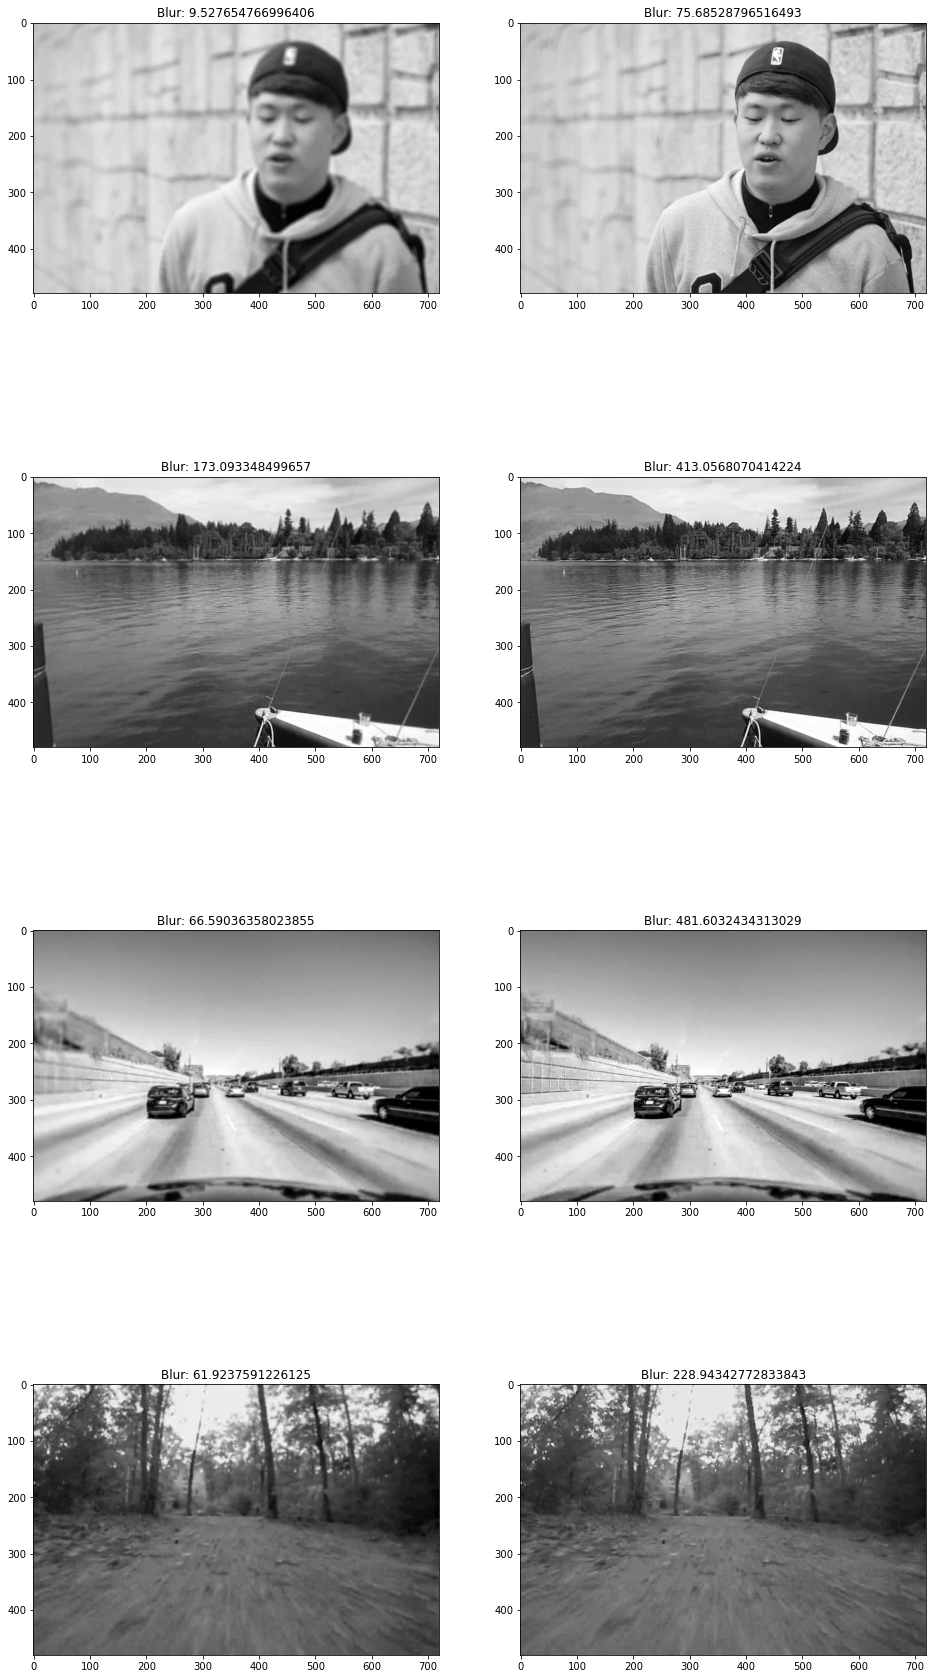

In [27]:
show_batch(training_data_loader,size =8)

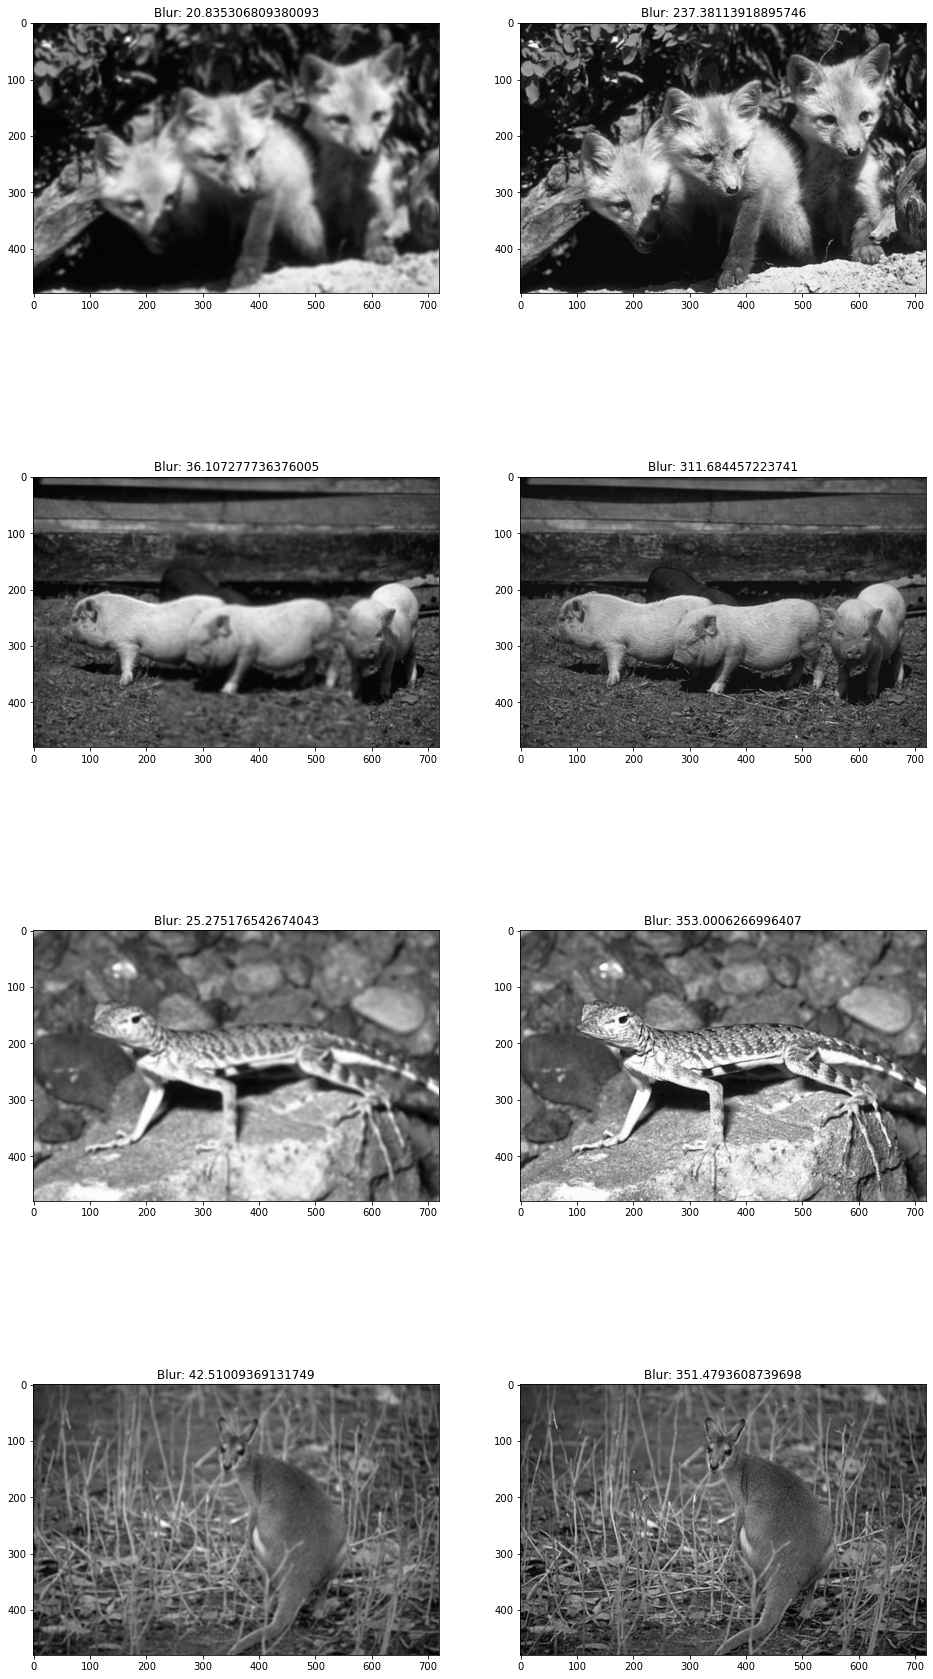

In [102]:
show_batch(valid_data_loader,size =8)

# NEW CNN

In [28]:
import torch.nn as nn

class NEWNet(nn.Module):
    def __init__(self, c1, c2):
        super(NEWNet, self).__init__()    
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels=c1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(in_channels=c1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv4 = nn.Conv2d(in_channels=c1, out_channels=c2, kernel_size=1, stride=1, padding=0, bias=True)
        self.conv5 = nn.Conv2d(in_channels=c2, out_channels=c2, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv6 = nn.Conv2d(in_channels=c2, out_channels=c1, kernel_size=1, stride=1, padding=0, bias=True)
        self.convf = nn.Conv2d(in_channels=c1, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):    
        residual = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        skip1 = x
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.conv6(x)
        x = x.add_(skip1)
        x = self.relu(x)
        x = self.convf(x)
        out = torch.add(x,residual)
        return out

# build the model

In [29]:
model = NEWNet(c1=64,c2=128)
model.cuda()

NEWNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (convf): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
)

In [30]:
num_pixels = crop_size[0] * crop_size[1]

In [31]:
def loss_scaler(im):
    # scale to -1,1 and convert to 3 channel (greyscale to RBG)
    return (im * 2 - 1).expand(-1, 3, -1, -1)

In [32]:
class Pixel_Loss(torch.nn.Module):
    
    def __init__(self,num_pixels):
        super(Pixel_Loss,self).__init__()
        self.lossfn = nn.MSELoss(reduction = 'mean')
        
        self.percep_loss_fn = lpips.LPIPS(net='alex').cuda()


        self.num_pixels = num_pixels
    #def forward(self,x,y):
        
     #   return self.num_pixels*(self.lossfn.forward(x,y))
    
    
    def forward(self,x,y):
        
        totloss = torch.mean(self.percep_loss_fn.forward(loss_scaler(x),loss_scaler(y)))
        #print("perceptual:",totloss)
        
        totloss.add_(50 * self.lossfn.forward(x,y))
        #print("total:",totloss)
        
        return totloss


In [33]:
criterion = Pixel_Loss(num_pixels)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /media/SSD/conda_env/superres/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [34]:
init_lr = .001
lr_step = 3
gradient_clip = 0.4
epochs = 12

In [35]:
#optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)


In [36]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [37]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [38]:
def save_checkpoint(experiment, model, epoch, valid_error):

    model_out_str = str(model_out_path/(model_name_base+"_epoch_{}.pth")).format(epoch)
    
    state = {"experiment": experiment, "epoch": epoch ,"model": model, "valid_error", valid_error}

    torch.save(state, model_out_str)

    print("Checkpoint saved to {}".format(model_out_str))

In [39]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
#import kornia


In [40]:
from torch.optim.swa_utils import AveragedModel
swa_model = torch.optim.swa_utils.AveragedModel(model)

In [41]:
def trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    cum_loss2=0
    cum_loss = 0
    ct=0
    ct2=0

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = batch[0], batch[1]

        
        input = input.cuda()
        
        target = target.cuda()
        
        optimizer.zero_grad()
        
        # Runs the forward pass with autocasting.
        with autocast():
            output = model(input)
            loss = criterion(output, target)
            
        
        
        
        scaler.scale(loss).backward()
        #loss.backward() 
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        
        #optimizer.step()
        scaler.step(optimizer)
        
        if epoch>1:
            swa_model.update_parameters(model)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        #scheduler.step()
        
        cum_loss = cum_loss + loss.data
        cum_loss2 = cum_loss2 + loss.data
        ct2=ct2+batch_size
        ct = ct +batch_size
        

        if iteration%10 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): LR: {} : TRaining Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), optimizer.param_groups[0]["lr"], cum_loss/ct))
            ct=0
            cum_loss =0
   
    print("Epoch Loss:", cum_loss2/ct2)        

In [108]:
def validatefp16(valid_data_loader, model, criterion, loop=10):

    model.eval()
    cum_loss2=0
    cum_loss = 0
    ct=0
    ct2=0

    for r in range(loop):
        for iteration, batch in enumerate(valid_data_loader, 1):
            input, target, camera_specs = batch[0], batch[1], batch[2]


            input = input.cuda()

            target = target.cuda()


            # Runs the forward pass with autocasting.
            with autocast():
                output = model(input)
                loss = criterion(output, target)


            cum_loss = cum_loss + loss.data
            cum_loss2 = cum_loss2 + loss.data
            ct2=ct2+batch_size
            ct = ct +batch_size
        

        
        print("===> Loop: {}  Validation Loss: {:.10f}".format(r, cum_loss/ct))
        ct=0
        cum_loss =0
   
    print("===> Epoch Validation Loss: {:.10f}".format(cum_loss2/ct2) )
    
    return (cum_loss2/ct2).item()

In [104]:
model = torch.load("/media/SSD/superres/checkpoint/NEWCNN_epoch_12.pth")["model"]

In [103]:
validatefp16(valid_data_loader, model, criterion, loop=10)

===> Loop: 0  Validation Loss: 0.0983276367
===> Loop: 1  Validation Loss: 0.1031494141
===> Loop: 2  Validation Loss: 0.0965576172
===> Loop: 3  Validation Loss: 0.0947265625
===> Loop: 4  Validation Loss: 0.0989379883
===> Loop: 5  Validation Loss: 0.1001586914
===> Loop: 6  Validation Loss: 0.0998535156
===> Loop: 7  Validation Loss: 0.0945434570
===> Loop: 8  Validation Loss: 0.1004028320
===> Loop: 9  Validation Loss: 0.0975952148
===> Epoch Validation Loss: 0.0984497070


tensor(0.0984, device='cuda:0', dtype=torch.float16)

In [107]:
validatefp16(valid_data_loader, model, criterion, loop=1).item()

===> Loop: 0  Validation Loss: 0.1080932617
===> Epoch Validation Loss: 0.1080932617


0.10809326171875

In [111]:
f1 = "/media/SSD/superres/checkpoint/NEWCNN_epoch_"
f3 = ".pth"
lst =[]
for i in range(1,13):
    model = torch.load(f1+str(i)+f3)["model"]
    lst.append(validatefp16(valid_data_loader, model, criterion, loop=10))
    print(lst)
    
    

===> Loop: 0  Validation Loss: 0.0993041992
===> Loop: 1  Validation Loss: 0.0958251953
===> Loop: 2  Validation Loss: 0.0971069336
===> Loop: 3  Validation Loss: 0.0990600586
===> Loop: 4  Validation Loss: 0.0956420898
===> Loop: 5  Validation Loss: 0.0957031250
===> Loop: 6  Validation Loss: 0.0977783203
===> Loop: 7  Validation Loss: 0.0989990234
===> Loop: 8  Validation Loss: 0.0984497070
===> Loop: 9  Validation Loss: 0.1017456055
===> Epoch Validation Loss: 0.0979614258
[0.09796142578125]
===> Loop: 0  Validation Loss: 0.1061401367
===> Loop: 1  Validation Loss: 0.1047973633
===> Loop: 2  Validation Loss: 0.1105957031
===> Loop: 3  Validation Loss: 0.1090698242
===> Loop: 4  Validation Loss: 0.1089477539
===> Loop: 5  Validation Loss: 0.1072387695
===> Loop: 6  Validation Loss: 0.1043090820
===> Loop: 7  Validation Loss: 0.1131591797
===> Loop: 8  Validation Loss: 0.1107177734
===> Loop: 9  Validation Loss: 0.1062622070
===> Epoch Validation Loss: 0.1079711914
[0.09796142578125, 

In [42]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        valid_error = validatefp16(valid_data_loader, model, criterion)
        save_checkpoint(NOTEBOOK_FULL_PATH, model, epoch, valid_error)

Start Time: 2020-10-21 21:01:25.685873
Epoch = 1, lr = 0.001
===> Time: 2020-10-21 21:01:33.730722 Epoch[1](10/1586): LR: 0.001 : Loss: 0.1520996094
===> Time: 2020-10-21 21:01:41.685938 Epoch[1](20/1586): LR: 0.001 : Loss: 0.1220703125
===> Time: 2020-10-21 21:01:49.635530 Epoch[1](30/1586): LR: 0.001 : Loss: 0.1269531250
===> Time: 2020-10-21 21:01:57.548374 Epoch[1](40/1586): LR: 0.001 : Loss: 0.1069335938
===> Time: 2020-10-21 21:02:05.321793 Epoch[1](50/1586): LR: 0.001 : Loss: 0.1223144531
===> Time: 2020-10-21 21:02:13.176287 Epoch[1](60/1586): LR: 0.001 : Loss: 0.0952148438
===> Time: 2020-10-21 21:02:21.282877 Epoch[1](70/1586): LR: 0.001 : Loss: 0.0969238281
===> Time: 2020-10-21 21:02:28.976491 Epoch[1](80/1586): LR: 0.001 : Loss: 0.0780639648
===> Time: 2020-10-21 21:02:36.675190 Epoch[1](90/1586): LR: 0.001 : Loss: 0.0791015625
===> Time: 2020-10-21 21:02:44.502933 Epoch[1](100/1586): LR: 0.001 : Loss: 0.0990600586
===> Time: 2020-10-21 21:02:52.209615 Epoch[1](110/1586): 

===> Time: 2020-10-21 21:13:17.835627 Epoch[1](930/1586): LR: 0.001 : Loss: 0.0714721680
===> Time: 2020-10-21 21:13:25.402818 Epoch[1](940/1586): LR: 0.001 : Loss: 0.0743408203
===> Time: 2020-10-21 21:13:33.258300 Epoch[1](950/1586): LR: 0.001 : Loss: 0.0689086914
===> Time: 2020-10-21 21:13:40.993144 Epoch[1](960/1586): LR: 0.001 : Loss: 0.1050415039
===> Time: 2020-10-21 21:13:48.420896 Epoch[1](970/1586): LR: 0.001 : Loss: 0.0820312500
===> Time: 2020-10-21 21:13:55.842735 Epoch[1](980/1586): LR: 0.001 : Loss: 0.0764160156
===> Time: 2020-10-21 21:14:03.272504 Epoch[1](990/1586): LR: 0.001 : Loss: 0.0707397461
===> Time: 2020-10-21 21:14:10.883500 Epoch[1](1000/1586): LR: 0.001 : Loss: 0.0709228516
===> Time: 2020-10-21 21:14:18.240582 Epoch[1](1010/1586): LR: 0.001 : Loss: 0.0849609375
===> Time: 2020-10-21 21:14:25.799780 Epoch[1](1020/1586): LR: 0.001 : Loss: 0.0713500977
===> Time: 2020-10-21 21:14:33.341515 Epoch[1](1030/1586): LR: 0.001 : Loss: 0.0784912109
===> Time: 2020-1

===> Time: 2020-10-21 21:24:31.413457 Epoch[2](250/1586): LR: 0.001 : Loss: 0.0825805664
===> Time: 2020-10-21 21:24:38.603332 Epoch[2](260/1586): LR: 0.001 : Loss: 0.0712280273
===> Time: 2020-10-21 21:24:45.907681 Epoch[2](270/1586): LR: 0.001 : Loss: 0.0761108398
===> Time: 2020-10-21 21:24:53.195110 Epoch[2](280/1586): LR: 0.001 : Loss: 0.0892333984
===> Time: 2020-10-21 21:25:00.438002 Epoch[2](290/1586): LR: 0.001 : Loss: 0.0726928711
===> Time: 2020-10-21 21:25:07.543834 Epoch[2](300/1586): LR: 0.001 : Loss: 0.0650024414
===> Time: 2020-10-21 21:25:14.919089 Epoch[2](310/1586): LR: 0.001 : Loss: 0.0849609375
===> Time: 2020-10-21 21:25:22.201970 Epoch[2](320/1586): LR: 0.001 : Loss: 0.0934448242
===> Time: 2020-10-21 21:25:29.390679 Epoch[2](330/1586): LR: 0.001 : Loss: 0.0715942383
===> Time: 2020-10-21 21:25:36.623631 Epoch[2](340/1586): LR: 0.001 : Loss: 0.0805664062
===> Time: 2020-10-21 21:25:43.783542 Epoch[2](350/1586): LR: 0.001 : Loss: 0.0749511719
===> Time: 2020-10-21

===> Time: 2020-10-21 21:35:40.115248 Epoch[2](1170/1586): LR: 0.001 : Loss: 0.1003417969
===> Time: 2020-10-21 21:35:47.202528 Epoch[2](1180/1586): LR: 0.001 : Loss: 0.0964355469
===> Time: 2020-10-21 21:35:54.521392 Epoch[2](1190/1586): LR: 0.001 : Loss: 0.0975952148
===> Time: 2020-10-21 21:36:02.088856 Epoch[2](1200/1586): LR: 0.001 : Loss: 0.1030273438
===> Time: 2020-10-21 21:36:09.436403 Epoch[2](1210/1586): LR: 0.001 : Loss: 0.0944824219
===> Time: 2020-10-21 21:36:16.952644 Epoch[2](1220/1586): LR: 0.001 : Loss: 0.0739135742
===> Time: 2020-10-21 21:36:24.261770 Epoch[2](1230/1586): LR: 0.001 : Loss: 0.0798339844
===> Time: 2020-10-21 21:36:31.342248 Epoch[2](1240/1586): LR: 0.001 : Loss: 0.0678710938
===> Time: 2020-10-21 21:36:38.687248 Epoch[2](1250/1586): LR: 0.001 : Loss: 0.0963134766
===> Time: 2020-10-21 21:36:45.861598 Epoch[2](1260/1586): LR: 0.001 : Loss: 0.0626220703
===> Time: 2020-10-21 21:36:53.067112 Epoch[2](1270/1586): LR: 0.001 : Loss: 0.0801391602
===> Time:

===> Time: 2020-10-21 21:46:37.665111 Epoch[3](490/1586): LR: 0.001 : Loss: 0.0728759766
===> Time: 2020-10-21 21:46:45.132033 Epoch[3](500/1586): LR: 0.001 : Loss: 0.0760498047
===> Time: 2020-10-21 21:46:52.250648 Epoch[3](510/1586): LR: 0.001 : Loss: 0.0603027344
===> Time: 2020-10-21 21:46:59.577717 Epoch[3](520/1586): LR: 0.001 : Loss: 0.0786132812
===> Time: 2020-10-21 21:47:06.994865 Epoch[3](530/1586): LR: 0.001 : Loss: 0.0826416016
===> Time: 2020-10-21 21:47:14.326535 Epoch[3](540/1586): LR: 0.001 : Loss: 0.0673828125
===> Time: 2020-10-21 21:47:21.700576 Epoch[3](550/1586): LR: 0.001 : Loss: 0.1007690430
===> Time: 2020-10-21 21:47:28.976882 Epoch[3](560/1586): LR: 0.001 : Loss: 0.0876464844
===> Time: 2020-10-21 21:47:36.101849 Epoch[3](570/1586): LR: 0.001 : Loss: 0.0864868164
===> Time: 2020-10-21 21:47:43.385435 Epoch[3](580/1586): LR: 0.001 : Loss: 0.0929565430
===> Time: 2020-10-21 21:47:50.894333 Epoch[3](590/1586): LR: 0.001 : Loss: 0.1032714844
===> Time: 2020-10-21

===> Time: 2020-10-21 21:57:39.090689 Epoch[3](1410/1586): LR: 0.001 : Loss: 0.0831298828
===> Time: 2020-10-21 21:57:46.489745 Epoch[3](1420/1586): LR: 0.001 : Loss: 0.0895385742
===> Time: 2020-10-21 21:57:53.582910 Epoch[3](1430/1586): LR: 0.001 : Loss: 0.0916748047
===> Time: 2020-10-21 21:58:00.881410 Epoch[3](1440/1586): LR: 0.001 : Loss: 0.1350097656
===> Time: 2020-10-21 21:58:07.915440 Epoch[3](1450/1586): LR: 0.001 : Loss: 0.0910644531
===> Time: 2020-10-21 21:58:15.065834 Epoch[3](1460/1586): LR: 0.001 : Loss: 0.0579833984
===> Time: 2020-10-21 21:58:22.315231 Epoch[3](1470/1586): LR: 0.001 : Loss: 0.1734619141
===> Time: 2020-10-21 21:58:29.500937 Epoch[3](1480/1586): LR: 0.001 : Loss: 0.0816040039
===> Time: 2020-10-21 21:58:36.852734 Epoch[3](1490/1586): LR: 0.001 : Loss: 0.1107177734
===> Time: 2020-10-21 21:58:44.034466 Epoch[3](1500/1586): LR: 0.001 : Loss: 0.0770263672
===> Time: 2020-10-21 21:58:51.303931 Epoch[3](1510/1586): LR: 0.001 : Loss: 0.0753173828
===> Time:

===> Time: 2020-10-21 22:07:12.475125 Epoch[4](620/1586): LR: 0.00031622776601683794 : Loss: 0.0676879883
===> Time: 2020-10-21 22:07:19.398871 Epoch[4](630/1586): LR: 0.00031622776601683794 : Loss: 0.0632324219
===> Time: 2020-10-21 22:07:26.502951 Epoch[4](640/1586): LR: 0.00031622776601683794 : Loss: 0.0841064453
===> Time: 2020-10-21 22:07:33.627179 Epoch[4](650/1586): LR: 0.00031622776601683794 : Loss: 0.0906982422
===> Time: 2020-10-21 22:07:40.598027 Epoch[4](660/1586): LR: 0.00031622776601683794 : Loss: 0.0729370117
===> Time: 2020-10-21 22:07:48.108550 Epoch[4](670/1586): LR: 0.00031622776601683794 : Loss: 0.1062011719
===> Time: 2020-10-21 22:07:55.290961 Epoch[4](680/1586): LR: 0.00031622776601683794 : Loss: 0.0651245117
===> Time: 2020-10-21 22:08:02.509372 Epoch[4](690/1586): LR: 0.00031622776601683794 : Loss: 0.0798339844
===> Time: 2020-10-21 22:08:09.470506 Epoch[4](700/1586): LR: 0.00031622776601683794 : Loss: 0.0917968750
===> Time: 2020-10-21 22:08:16.748406 Epoch[4]

===> Time: 2020-10-21 22:16:23.465613 Epoch[4](1390/1586): LR: 0.00031622776601683794 : Loss: 0.0710449219
===> Time: 2020-10-21 22:16:30.596158 Epoch[4](1400/1586): LR: 0.00031622776601683794 : Loss: 0.1262207031
===> Time: 2020-10-21 22:16:37.735589 Epoch[4](1410/1586): LR: 0.00031622776601683794 : Loss: 0.0679321289
===> Time: 2020-10-21 22:16:45.207099 Epoch[4](1420/1586): LR: 0.00031622776601683794 : Loss: 0.0654296875
===> Time: 2020-10-21 22:16:52.286289 Epoch[4](1430/1586): LR: 0.00031622776601683794 : Loss: 0.0792846680
===> Time: 2020-10-21 22:16:59.590579 Epoch[4](1440/1586): LR: 0.00031622776601683794 : Loss: 0.0736083984
===> Time: 2020-10-21 22:17:06.457681 Epoch[4](1450/1586): LR: 0.00031622776601683794 : Loss: 0.0701293945
===> Time: 2020-10-21 22:17:13.341402 Epoch[4](1460/1586): LR: 0.00031622776601683794 : Loss: 0.0886230469
===> Time: 2020-10-21 22:17:20.712557 Epoch[4](1470/1586): LR: 0.00031622776601683794 : Loss: 0.0806884766
===> Time: 2020-10-21 22:17:27.786168

===> Time: 2020-10-21 22:25:34.089267 Epoch[5](570/1586): LR: 0.00031622776601683794 : Loss: 0.1083984375
===> Time: 2020-10-21 22:25:41.076389 Epoch[5](580/1586): LR: 0.00031622776601683794 : Loss: 0.0725097656
===> Time: 2020-10-21 22:25:48.247062 Epoch[5](590/1586): LR: 0.00031622776601683794 : Loss: 0.0681762695
===> Time: 2020-10-21 22:25:55.349736 Epoch[5](600/1586): LR: 0.00031622776601683794 : Loss: 0.0840454102
===> Time: 2020-10-21 22:26:02.364398 Epoch[5](610/1586): LR: 0.00031622776601683794 : Loss: 0.0944213867
===> Time: 2020-10-21 22:26:09.455957 Epoch[5](620/1586): LR: 0.00031622776601683794 : Loss: 0.0651855469
===> Time: 2020-10-21 22:26:16.662238 Epoch[5](630/1586): LR: 0.00031622776601683794 : Loss: 0.0671997070
===> Time: 2020-10-21 22:26:23.879261 Epoch[5](640/1586): LR: 0.00031622776601683794 : Loss: 0.0926513672
===> Time: 2020-10-21 22:26:30.970001 Epoch[5](650/1586): LR: 0.00031622776601683794 : Loss: 0.0734252930
===> Time: 2020-10-21 22:26:38.417409 Epoch[5]

===> Time: 2020-10-21 22:34:48.862045 Epoch[5](1340/1586): LR: 0.00031622776601683794 : Loss: 0.0764160156
===> Time: 2020-10-21 22:34:55.995492 Epoch[5](1350/1586): LR: 0.00031622776601683794 : Loss: 0.1138305664
===> Time: 2020-10-21 22:35:02.969220 Epoch[5](1360/1586): LR: 0.00031622776601683794 : Loss: 0.0616149902
===> Time: 2020-10-21 22:35:09.981220 Epoch[5](1370/1586): LR: 0.00031622776601683794 : Loss: 0.0799560547
===> Time: 2020-10-21 22:35:17.428281 Epoch[5](1380/1586): LR: 0.00031622776601683794 : Loss: 0.0830078125
===> Time: 2020-10-21 22:35:24.488454 Epoch[5](1390/1586): LR: 0.00031622776601683794 : Loss: 0.0884399414
===> Time: 2020-10-21 22:35:31.653814 Epoch[5](1400/1586): LR: 0.00031622776601683794 : Loss: 0.0671997070
===> Time: 2020-10-21 22:35:38.932686 Epoch[5](1410/1586): LR: 0.00031622776601683794 : Loss: 0.0954589844
===> Time: 2020-10-21 22:35:46.355143 Epoch[5](1420/1586): LR: 0.00031622776601683794 : Loss: 0.0852050781
===> Time: 2020-10-21 22:35:53.405941

===> Time: 2020-10-21 22:43:57.642554 Epoch[6](520/1586): LR: 0.00031622776601683794 : Loss: 0.0908203125
===> Time: 2020-10-21 22:44:05.015054 Epoch[6](530/1586): LR: 0.00031622776601683794 : Loss: 0.0747070312
===> Time: 2020-10-21 22:44:12.291486 Epoch[6](540/1586): LR: 0.00031622776601683794 : Loss: 0.0756835938
===> Time: 2020-10-21 22:44:19.462461 Epoch[6](550/1586): LR: 0.00031622776601683794 : Loss: 0.1550292969
===> Time: 2020-10-21 22:44:26.687799 Epoch[6](560/1586): LR: 0.00031622776601683794 : Loss: 0.0764160156
===> Time: 2020-10-21 22:44:34.249091 Epoch[6](570/1586): LR: 0.00031622776601683794 : Loss: 0.0706176758
===> Time: 2020-10-21 22:44:41.471460 Epoch[6](580/1586): LR: 0.00031622776601683794 : Loss: 0.0930175781
===> Time: 2020-10-21 22:44:48.659712 Epoch[6](590/1586): LR: 0.00031622776601683794 : Loss: 0.1113891602
===> Time: 2020-10-21 22:44:55.826902 Epoch[6](600/1586): LR: 0.00031622776601683794 : Loss: 0.0802612305
===> Time: 2020-10-21 22:45:03.100269 Epoch[6]

===> Time: 2020-10-21 22:53:24.755140 Epoch[6](1300/1586): LR: 0.00031622776601683794 : Loss: 0.0584716797
===> Time: 2020-10-21 22:53:32.180838 Epoch[6](1310/1586): LR: 0.00031622776601683794 : Loss: 0.0676269531
===> Time: 2020-10-21 22:53:39.389557 Epoch[6](1320/1586): LR: 0.00031622776601683794 : Loss: 0.0741577148
===> Time: 2020-10-21 22:53:46.813985 Epoch[6](1330/1586): LR: 0.00031622776601683794 : Loss: 0.0855102539
===> Time: 2020-10-21 22:53:54.197674 Epoch[6](1340/1586): LR: 0.00031622776601683794 : Loss: 0.1149902344
===> Time: 2020-10-21 22:54:01.527847 Epoch[6](1350/1586): LR: 0.00031622776601683794 : Loss: 0.0557861328
===> Time: 2020-10-21 22:54:08.690348 Epoch[6](1360/1586): LR: 0.00031622776601683794 : Loss: 0.1246948242
===> Time: 2020-10-21 22:54:15.844216 Epoch[6](1370/1586): LR: 0.00031622776601683794 : Loss: 0.0983276367
===> Time: 2020-10-21 22:54:23.050503 Epoch[6](1380/1586): LR: 0.00031622776601683794 : Loss: 0.0773925781
===> Time: 2020-10-21 22:54:30.214863

===> Time: 2020-10-21 23:03:39.461775 Epoch[7](560/1586): LR: 0.0001 : Loss: 0.0770263672
===> Time: 2020-10-21 23:03:46.603797 Epoch[7](570/1586): LR: 0.0001 : Loss: 0.2012939453
===> Time: 2020-10-21 23:03:53.837692 Epoch[7](580/1586): LR: 0.0001 : Loss: 0.1033935547
===> Time: 2020-10-21 23:04:00.939113 Epoch[7](590/1586): LR: 0.0001 : Loss: 0.0748901367
===> Time: 2020-10-21 23:04:07.949404 Epoch[7](600/1586): LR: 0.0001 : Loss: 0.0744018555
===> Time: 2020-10-21 23:04:15.293758 Epoch[7](610/1586): LR: 0.0001 : Loss: 0.0645141602
===> Time: 2020-10-21 23:04:22.539626 Epoch[7](620/1586): LR: 0.0001 : Loss: 0.1246948242
===> Time: 2020-10-21 23:04:29.910184 Epoch[7](630/1586): LR: 0.0001 : Loss: 0.0872802734
===> Time: 2020-10-21 23:04:37.241561 Epoch[7](640/1586): LR: 0.0001 : Loss: 0.0977172852
===> Time: 2020-10-21 23:04:44.241242 Epoch[7](650/1586): LR: 0.0001 : Loss: 0.1993408203
===> Time: 2020-10-21 23:04:51.507317 Epoch[7](660/1586): LR: 0.0001 : Loss: 0.1103515625
===> Time:

===> Time: 2020-10-21 23:14:38.457933 Epoch[7](1470/1586): LR: 0.0001 : Loss: 0.0772705078
===> Time: 2020-10-21 23:14:45.853127 Epoch[7](1480/1586): LR: 0.0001 : Loss: 0.0870361328
===> Time: 2020-10-21 23:14:52.962100 Epoch[7](1490/1586): LR: 0.0001 : Loss: 0.0705566406
===> Time: 2020-10-21 23:15:00.112055 Epoch[7](1500/1586): LR: 0.0001 : Loss: 0.0723876953
===> Time: 2020-10-21 23:15:07.298822 Epoch[7](1510/1586): LR: 0.0001 : Loss: 0.0680541992
===> Time: 2020-10-21 23:15:14.504572 Epoch[7](1520/1586): LR: 0.0001 : Loss: 0.0594177246
===> Time: 2020-10-21 23:15:21.830173 Epoch[7](1530/1586): LR: 0.0001 : Loss: 0.0935058594
===> Time: 2020-10-21 23:15:28.953013 Epoch[7](1540/1586): LR: 0.0001 : Loss: 0.0623474121
===> Time: 2020-10-21 23:15:36.045647 Epoch[7](1550/1586): LR: 0.0001 : Loss: 0.0947265625
===> Time: 2020-10-21 23:15:43.499806 Epoch[7](1560/1586): LR: 0.0001 : Loss: 0.0936279297
===> Time: 2020-10-21 23:15:50.670693 Epoch[7](1570/1586): LR: 0.0001 : Loss: 0.0633544922

===> Time: 2020-10-21 23:25:24.801791 Epoch[8](780/1586): LR: 0.0001 : Loss: 0.0709838867
===> Time: 2020-10-21 23:25:31.907081 Epoch[8](790/1586): LR: 0.0001 : Loss: 0.0730590820
===> Time: 2020-10-21 23:25:38.927727 Epoch[8](800/1586): LR: 0.0001 : Loss: 0.1052246094
===> Time: 2020-10-21 23:25:46.067389 Epoch[8](810/1586): LR: 0.0001 : Loss: 0.1076660156
===> Time: 2020-10-21 23:25:53.382078 Epoch[8](820/1586): LR: 0.0001 : Loss: 0.0748901367
===> Time: 2020-10-21 23:26:00.386762 Epoch[8](830/1586): LR: 0.0001 : Loss: 0.2233886719
===> Time: 2020-10-21 23:26:07.382037 Epoch[8](840/1586): LR: 0.0001 : Loss: 0.0959472656
===> Time: 2020-10-21 23:26:14.709593 Epoch[8](850/1586): LR: 0.0001 : Loss: 0.2478027344
===> Time: 2020-10-21 23:26:21.825059 Epoch[8](860/1586): LR: 0.0001 : Loss: 0.0698852539
===> Time: 2020-10-21 23:26:28.905099 Epoch[8](870/1586): LR: 0.0001 : Loss: 0.0823974609
===> Time: 2020-10-21 23:26:36.040526 Epoch[8](880/1586): LR: 0.0001 : Loss: 0.0762329102
===> Time:

===> Time: 2020-10-21 23:36:06.192694 Epoch[9](90/1586): LR: 0.0001 : Loss: 0.0783081055
===> Time: 2020-10-21 23:36:13.382098 Epoch[9](100/1586): LR: 0.0001 : Loss: 0.0784912109
===> Time: 2020-10-21 23:36:20.489004 Epoch[9](110/1586): LR: 0.0001 : Loss: 0.0947265625
===> Time: 2020-10-21 23:36:27.972217 Epoch[9](120/1586): LR: 0.0001 : Loss: 0.0710449219
===> Time: 2020-10-21 23:36:35.164857 Epoch[9](130/1586): LR: 0.0001 : Loss: 0.1045532227
===> Time: 2020-10-21 23:36:42.395452 Epoch[9](140/1586): LR: 0.0001 : Loss: 0.0676269531
===> Time: 2020-10-21 23:36:49.584418 Epoch[9](150/1586): LR: 0.0001 : Loss: 0.0662231445
===> Time: 2020-10-21 23:36:56.666397 Epoch[9](160/1586): LR: 0.0001 : Loss: 0.0864257812
===> Time: 2020-10-21 23:37:03.864930 Epoch[9](170/1586): LR: 0.0001 : Loss: 0.0657348633
===> Time: 2020-10-21 23:37:11.166586 Epoch[9](180/1586): LR: 0.0001 : Loss: 0.0662231445
===> Time: 2020-10-21 23:37:18.465578 Epoch[9](190/1586): LR: 0.0001 : Loss: 0.0773315430
===> Time: 

===> Time: 2020-10-21 23:47:05.145024 Epoch[9](1010/1586): LR: 0.0001 : Loss: 0.1027221680
===> Time: 2020-10-21 23:47:12.416320 Epoch[9](1020/1586): LR: 0.0001 : Loss: 0.0966796875
===> Time: 2020-10-21 23:47:19.588988 Epoch[9](1030/1586): LR: 0.0001 : Loss: 0.0916748047
===> Time: 2020-10-21 23:47:26.931064 Epoch[9](1040/1586): LR: 0.0001 : Loss: 0.0989990234
===> Time: 2020-10-21 23:47:34.122732 Epoch[9](1050/1586): LR: 0.0001 : Loss: 0.0743408203
===> Time: 2020-10-21 23:47:41.383929 Epoch[9](1060/1586): LR: 0.0001 : Loss: 0.0706176758
===> Time: 2020-10-21 23:47:48.540721 Epoch[9](1070/1586): LR: 0.0001 : Loss: 0.0761108398
===> Time: 2020-10-21 23:47:55.818584 Epoch[9](1080/1586): LR: 0.0001 : Loss: 0.0888061523
===> Time: 2020-10-21 23:48:02.855713 Epoch[9](1090/1586): LR: 0.0001 : Loss: 0.0874633789
===> Time: 2020-10-21 23:48:09.935147 Epoch[9](1100/1586): LR: 0.0001 : Loss: 0.0666503906
===> Time: 2020-10-21 23:48:16.941919 Epoch[9](1110/1586): LR: 0.0001 : Loss: 0.0820312500

===> Time: 2020-10-21 23:57:13.502935 Epoch[10](270/1586): LR: 3.16227766016838e-05 : Loss: 0.0648803711
===> Time: 2020-10-21 23:57:20.633608 Epoch[10](280/1586): LR: 3.16227766016838e-05 : Loss: 0.0730590820
===> Time: 2020-10-21 23:57:27.846221 Epoch[10](290/1586): LR: 3.16227766016838e-05 : Loss: 0.0808105469
===> Time: 2020-10-21 23:57:35.093458 Epoch[10](300/1586): LR: 3.16227766016838e-05 : Loss: 0.1008300781
===> Time: 2020-10-21 23:57:42.145249 Epoch[10](310/1586): LR: 3.16227766016838e-05 : Loss: 0.0734252930
===> Time: 2020-10-21 23:57:49.219261 Epoch[10](320/1586): LR: 3.16227766016838e-05 : Loss: 0.0686645508
===> Time: 2020-10-21 23:57:56.108089 Epoch[10](330/1586): LR: 3.16227766016838e-05 : Loss: 0.0723876953
===> Time: 2020-10-21 23:58:03.345377 Epoch[10](340/1586): LR: 3.16227766016838e-05 : Loss: 0.0930786133
===> Time: 2020-10-21 23:58:10.515283 Epoch[10](350/1586): LR: 3.16227766016838e-05 : Loss: 0.0766601562
===> Time: 2020-10-21 23:58:17.640698 Epoch[10](360/158

===> Time: 2020-10-22 00:06:32.428252 Epoch[10](1050/1586): LR: 3.16227766016838e-05 : Loss: 0.1060180664
===> Time: 2020-10-22 00:06:39.596356 Epoch[10](1060/1586): LR: 3.16227766016838e-05 : Loss: 0.1149902344
===> Time: 2020-10-22 00:06:46.721621 Epoch[10](1070/1586): LR: 3.16227766016838e-05 : Loss: 0.0665283203
===> Time: 2020-10-22 00:06:54.128630 Epoch[10](1080/1586): LR: 3.16227766016838e-05 : Loss: 0.0797729492
===> Time: 2020-10-22 00:07:01.271146 Epoch[10](1090/1586): LR: 3.16227766016838e-05 : Loss: 0.1750488281
===> Time: 2020-10-22 00:07:08.301141 Epoch[10](1100/1586): LR: 3.16227766016838e-05 : Loss: 0.0661010742
===> Time: 2020-10-22 00:07:15.204713 Epoch[10](1110/1586): LR: 3.16227766016838e-05 : Loss: 0.0770874023
===> Time: 2020-10-22 00:07:22.320881 Epoch[10](1120/1586): LR: 3.16227766016838e-05 : Loss: 0.0989379883
===> Time: 2020-10-22 00:07:29.365591 Epoch[10](1130/1586): LR: 3.16227766016838e-05 : Loss: 0.0825805664
===> Time: 2020-10-22 00:07:36.530709 Epoch[10

===> Time: 2020-10-22 00:15:40.179518 Epoch[11](230/1586): LR: 3.16227766016838e-05 : Loss: 0.0894165039
===> Time: 2020-10-22 00:15:47.610628 Epoch[11](240/1586): LR: 3.16227766016838e-05 : Loss: 0.0783081055
===> Time: 2020-10-22 00:15:54.659997 Epoch[11](250/1586): LR: 3.16227766016838e-05 : Loss: 0.0656127930
===> Time: 2020-10-22 00:16:01.578418 Epoch[11](260/1586): LR: 3.16227766016838e-05 : Loss: 0.0916748047
===> Time: 2020-10-22 00:16:08.871286 Epoch[11](270/1586): LR: 3.16227766016838e-05 : Loss: 0.0558471680
===> Time: 2020-10-22 00:16:16.087261 Epoch[11](280/1586): LR: 3.16227766016838e-05 : Loss: 0.0730590820
===> Time: 2020-10-22 00:16:23.083257 Epoch[11](290/1586): LR: 3.16227766016838e-05 : Loss: 0.0657958984
===> Time: 2020-10-22 00:16:30.068395 Epoch[11](300/1586): LR: 3.16227766016838e-05 : Loss: 0.1162719727
===> Time: 2020-10-22 00:16:37.352237 Epoch[11](310/1586): LR: 3.16227766016838e-05 : Loss: 0.1090698242
===> Time: 2020-10-22 00:16:44.559726 Epoch[11](320/158

===> Time: 2020-10-22 00:25:06.881202 Epoch[11](1020/1586): LR: 3.16227766016838e-05 : Loss: 0.0913696289
===> Time: 2020-10-22 00:25:14.099241 Epoch[11](1030/1586): LR: 3.16227766016838e-05 : Loss: 0.0870361328
===> Time: 2020-10-22 00:25:21.235357 Epoch[11](1040/1586): LR: 3.16227766016838e-05 : Loss: 0.0642700195
===> Time: 2020-10-22 00:25:28.615278 Epoch[11](1050/1586): LR: 3.16227766016838e-05 : Loss: 0.1049804688
===> Time: 2020-10-22 00:25:35.730629 Epoch[11](1060/1586): LR: 3.16227766016838e-05 : Loss: 0.0993652344
===> Time: 2020-10-22 00:25:42.812979 Epoch[11](1070/1586): LR: 3.16227766016838e-05 : Loss: 0.1254882812
===> Time: 2020-10-22 00:25:50.034991 Epoch[11](1080/1586): LR: 3.16227766016838e-05 : Loss: 0.0714721680
===> Time: 2020-10-22 00:25:57.281029 Epoch[11](1090/1586): LR: 3.16227766016838e-05 : Loss: 0.0652465820
===> Time: 2020-10-22 00:26:04.626558 Epoch[11](1100/1586): LR: 3.16227766016838e-05 : Loss: 0.0904541016
===> Time: 2020-10-22 00:26:11.991227 Epoch[11

===> Time: 2020-10-22 00:34:18.785077 Epoch[12](200/1586): LR: 3.16227766016838e-05 : Loss: 0.0668945312
===> Time: 2020-10-22 00:34:26.110277 Epoch[12](210/1586): LR: 3.16227766016838e-05 : Loss: 0.0893554688
===> Time: 2020-10-22 00:34:33.397529 Epoch[12](220/1586): LR: 3.16227766016838e-05 : Loss: 0.0603027344
===> Time: 2020-10-22 00:34:40.544584 Epoch[12](230/1586): LR: 3.16227766016838e-05 : Loss: 0.1204833984
===> Time: 2020-10-22 00:34:47.906332 Epoch[12](240/1586): LR: 3.16227766016838e-05 : Loss: 0.1467285156
===> Time: 2020-10-22 00:34:55.113163 Epoch[12](250/1586): LR: 3.16227766016838e-05 : Loss: 0.0658569336
===> Time: 2020-10-22 00:35:02.342220 Epoch[12](260/1586): LR: 3.16227766016838e-05 : Loss: 0.0556030273
===> Time: 2020-10-22 00:35:09.663009 Epoch[12](270/1586): LR: 3.16227766016838e-05 : Loss: 0.0609741211
===> Time: 2020-10-22 00:35:17.100247 Epoch[12](280/1586): LR: 3.16227766016838e-05 : Loss: 0.0952758789
===> Time: 2020-10-22 00:35:24.411833 Epoch[12](290/158

===> Time: 2020-10-22 00:43:46.876699 Epoch[12](990/1586): LR: 3.16227766016838e-05 : Loss: 0.0677490234
===> Time: 2020-10-22 00:43:54.108271 Epoch[12](1000/1586): LR: 3.16227766016838e-05 : Loss: 0.0639648438
===> Time: 2020-10-22 00:44:01.347481 Epoch[12](1010/1586): LR: 3.16227766016838e-05 : Loss: 0.0625610352
===> Time: 2020-10-22 00:44:08.397605 Epoch[12](1020/1586): LR: 3.16227766016838e-05 : Loss: 0.0798339844
===> Time: 2020-10-22 00:44:15.617604 Epoch[12](1030/1586): LR: 3.16227766016838e-05 : Loss: 0.0630493164
===> Time: 2020-10-22 00:44:23.015751 Epoch[12](1040/1586): LR: 3.16227766016838e-05 : Loss: 0.0781860352
===> Time: 2020-10-22 00:44:30.303840 Epoch[12](1050/1586): LR: 3.16227766016838e-05 : Loss: 0.0679931641
===> Time: 2020-10-22 00:44:37.490170 Epoch[12](1060/1586): LR: 3.16227766016838e-05 : Loss: 0.0821533203
===> Time: 2020-10-22 00:44:44.596232 Epoch[12](1070/1586): LR: 3.16227766016838e-05 : Loss: 0.0607910156
===> Time: 2020-10-22 00:44:51.696118 Epoch[12]

Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [43]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize_cv(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

In [44]:
def decolorize_cv(frame):
    im_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
    im_b_y = im_ycbcr[:,:,0].astype(float)
    im_grey = im_b_y/255.0
    return im_grey, im_ycbcr

In [45]:
from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            
            if channels == 1:
                im_input, im_b_ycbcr = decolorize_cv(frame)

                im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
                im_input = im_input.cuda()

                with autocast():
                    out = model(im_input)
                out = (out*255.0).clamp(0,255)

                out = out.cpu()

                im_h_y = out.data[0].numpy().astype(np.float32)

                im_h_y = im_h_y[0,:,:]

                im_h = colorize_cv(im_h_y, im_b_ycbcr)
            elif channels == 3:
                im_input = frame/255.
                im_input = Variable(torch.from_numpy(im_input).float()).\
                view(1, 3, im_input.shape[0], im_input.shape[1])
        
  
                im_input = im_input.cuda()
    
                
                
                with autocast():
                    out = model(im_input)
                out = (out*255.0).clamp(0,255)

                out = out.cpu()
                
                im_h = out.data[0].view(im_input.shape[2], im_input.shape[3],3).numpy().astype(np.uint8)

                #im_h = out.data[0].numpy().astype(np.float32)

            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

# compare to benchmarks

In [46]:
from PIL import Image
import math
import matplotlib.pyplot as plt

In [47]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [48]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [49]:
def decolorize(x):
    x_ycbcr = cv2.cvtColor(x, cv2.COLOR_BGR2YCR_CB)
    x_y = x_ycbcr[:,:,0].astype(float)
    return x_y, x_ycbcr

In [50]:
percept_loss= Pixel_Loss(num_pixels)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /media/SSD/conda_env/superres/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [51]:
def display_PSNR(im_gt, im_b, im_in, model,channels=1, display=True):
    

    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_in_ycbcr = np.array(im_in.convert("YCbCr"))
    
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    im_in_y = im_in_ycbcr[:,:,0].astype(float)
    
    #psnr_bicubic = PSNR(im_gt_y, im_b_y)
    #psnr_input = PSNR(im_gt_y, im_in_y)
    psnr_bicubic = PSNR(np.array(im_gt),np.array( im_b))
    psnr_input = PSNR(np.array(im_gt), np.array(im_in))
    
    im_i_ycbcr = np.array(im_in.convert("YCbCr"))
    im_i_y = im_i_ycbcr[:,:,0].astype(float)
        
    # Prepare for the input, a pytorch tensor
    if channels == 1:
        im_input = im_i_y/255.
        im_input = Variable(torch.from_numpy(im_input).float()).\
        view(1, -1, im_input.shape[0], im_input.shape[1])
    
    if channels ==3:
        im_input = np.array(im_in)/255.0
        #im_input = np.array(im_in)
        im_input = Variable(torch.from_numpy(im_input).float()).\
        view(1, 3, im_input.shape[0], im_input.shape[1])
        
    #print("im_input.shape=",im_input.shape)    
    im_input = im_input.cuda()
    
    with autocast():
        out = model(im_input)
    
    out = (out*255.0).clamp(0,255)
    
    out = out.cpu()
    
    if channels == 1:
        im_y = out.data[0].numpy().astype(np.float32)
        im_h_y = im_y[0,:,:]
        im_h = np.array(colorize(im_h_y, im_b_ycbcr))

    elif channels ==3:
        #print("out[0]=",out[0].shape)
        #print("out.data[0]=",out.data[0].shape)
        #print("im_input.shape=",im_input.shape)
        im_h = out.data[0].view(im_input.shape[2], im_input.shape[3],3).numpy().astype(np.uint8)
        #print("im.h.shape=",im_h.shape)
        im_h_y, _ = decolorize(im_h)
        
    
    # Calculate the PNSR for prediction
    #psnr_predicted = PSNR(im_gt_y, im_h_y)
    psnr_predicted = PSNR(np.array(im_gt), np.array(im_h))
    
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_bicubic = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_i_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    #percept_loss_input = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_in))
    #percept_loss_bicubic = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_b))
    #percept_loss_predict = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_h))
    
    # Colorize the grey-level image and convert into RGB mode

    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    if display:
    
        print('psnr for bicubic is {}dB'.format(psnr_bicubic))
        print('psnr for input is {}dB'.format(psnr_input))
        
        print('psnr for Model is {}dB'.format(psnr_predicted))
        print("PSNR improvement is {}dB".format(psnr_predicted - psnr_input))

        print("Sharpness Measurement GroundTruth:",blur_measure_gt)
        print("Sharpness Measurement Bicubic:",blur_measure_bicubic)
        print("Sharpness Measurement Input:",blur_measure_input)
        print("Sharpness Measurement Model:",blur_measure_vdsr)
        
        #print('perception loss for bicubic is {}'.format(percept_loss_bicubic))
        #print('perception loss for input is {}'.format(percept_loss_input))
        
        #print('perception loss for Model is {}'.format(percept_loss_predict))

        # Result visualization
        fig = plt.figure(figsize=(18, 16), dpi= 80)
        ax = plt.subplot(151)
        ax.imshow(im_gt)
        ax.set_title("GT")

        ax = plt.subplot(152)
        ax.imshow(im_b)
        ax.set_title("Bicubic")

        ax = plt.subplot(153)
        ax.imshow(im_in)
        ax.set_title("Input")

        ax = plt.subplot(154)
        ax.imshow(im_h)
        ax.set_title("Output(Model)")
        
        
        ax = plt.subplot(155)
        ax.imshow(np.clip(im_h-im_in +128,0,255))
        ax.set_title("Model-Input")
        plt.show()
    
    return im_h, psnr_bicubic, psnr_predicted

In [52]:
#model = torch.load("/media/SSD/superres/checkpoint/VDNEW2_epoch_15.pth")["model"]

In [94]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")



im_b2 = pil_disk_blur(im_gt,6)


psnr for bicubic is 30.222371136419135dB
psnr for input is 28.501681302217943dB
psnr for Model is 29.38360084850119dB
PSNR improvement is 0.8819195462832461dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 68.66161937173456
Sharpness Measurement Input: 97.89891300513409
Sharpness Measurement Model: 302.3796043395996


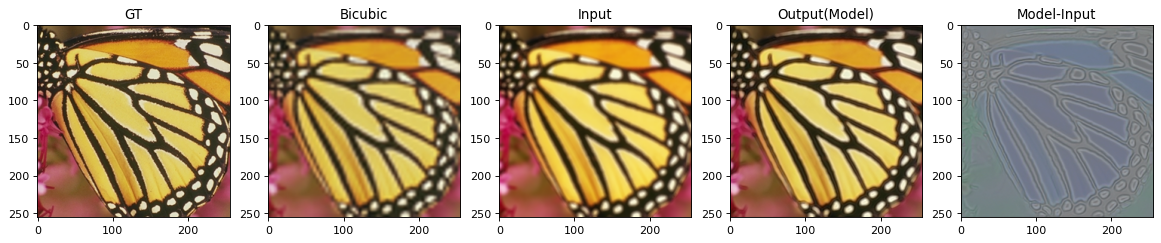

In [95]:
display_PSNR(im_gt, im_b, im_b2, model, channels=1);


In [55]:
# Make this load still photos too, and have them added with frame = 0
def test_results(test_dir,scale, channels=1, display = False):
    instances = []
    psnr_bicubic_sum = 0
    psnr_model_sum = 0
    ct = 0
    
    for filename in listdir(test_dir):
        filepath = os.path.join(test_dir,filename)
        #print(filepath)
                
        if is_image_file(filepath):
            im_gt = Image.open(filepath).convert("RGB")
            #print(im_gt.size)
            
            (height, width) = im_gt.size
            im_b = im_gt.resize((int(height/scale), int(width/scale)), resample = Image.BICUBIC)
            im_b = im_b.resize((height,width), resample = Image.BICUBIC)
            im_b2 = pil_disk_blur(im_gt,scale*2)
            
            im_h, psnr_bicubic, psnr_predicted = display_PSNR(im_gt, im_b, im_b2, model, channels=channels, display = display)
            psnr_bicubic_sum = psnr_bicubic_sum + psnr_bicubic
            psnr_model_sum = psnr_model_sum + psnr_predicted
            ct = ct +1
            #item = {"Filepath":filepath, "Type":"image"}
            #instances.append(item)
        
    psnr_bicubic_avg = psnr_bicubic_sum / ct
    psnr_model_avg = psnr_model_sum / ct
        
    print("Bicubic average PSNR =",psnr_bicubic_avg)
    print("Model average PSNR =",psnr_model_avg)
    return 



psnr for bicubic is 33.390163695766894dB
psnr for input is 32.79310964459529dB
psnr for Model is 28.63024250625243dB
PSNR improvement is -4.162867138342861dB
Sharpness Measurement GroundTruth: 247.28295878820063
Sharpness Measurement Bicubic: 9.535258178118966
Sharpness Measurement Input: 5.858893811702728
Sharpness Measurement Model: 17.23854188491532


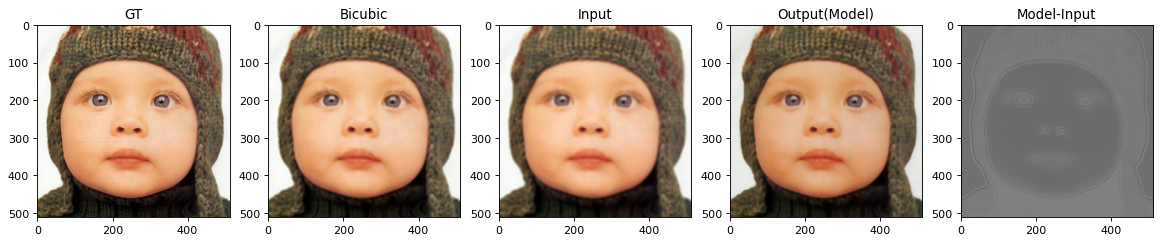

psnr for bicubic is 32.235298592507704dB
psnr for input is 31.382772027682307dB
psnr for Model is 28.989293872388163dB
PSNR improvement is -2.3934781552941438dB
Sharpness Measurement GroundTruth: 726.1960912189749
Sharpness Measurement Bicubic: 24.910532272341808
Sharpness Measurement Input: 14.338576666300607
Sharpness Measurement Model: 49.720071291898684


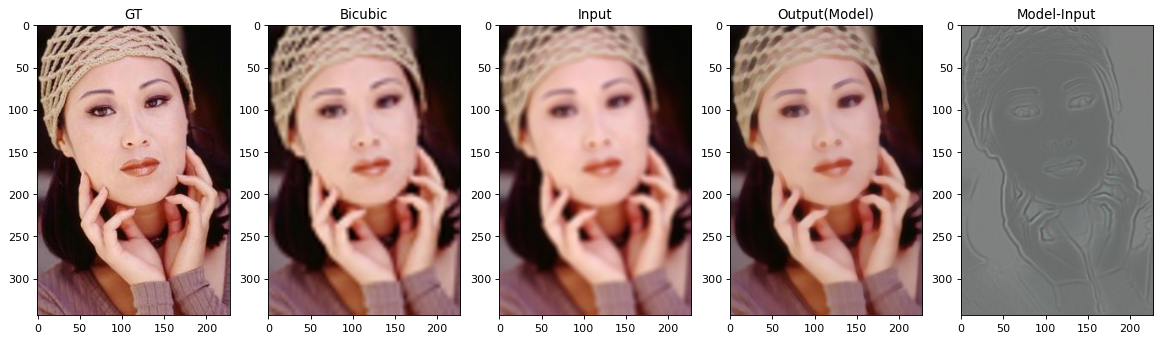

psnr for bicubic is 30.211868582917297dB
psnr for input is 28.432968257934547dB
psnr for Model is 28.978512995095574dB
PSNR improvement is 0.5455447371610269dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 68.43807946145535
Sharpness Measurement Input: 54.08266585692763
Sharpness Measurement Model: 196.01058398839086


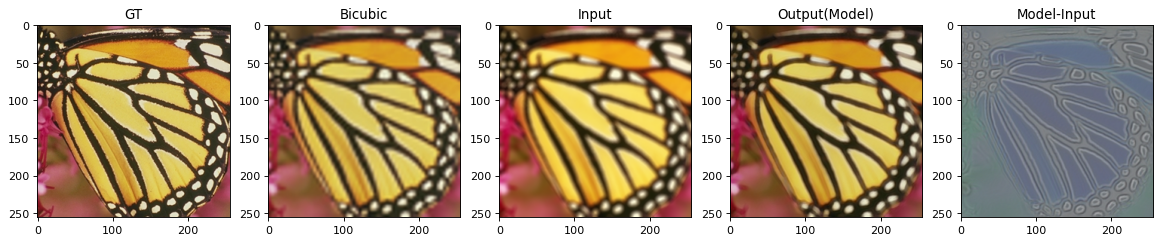

psnr for bicubic is 31.72207407894435dB
psnr for input is 31.14274836086718dB
psnr for Model is 29.975761113290975dB
PSNR improvement is -1.1669872475762055dB
Sharpness Measurement GroundTruth: 593.2631865654935
Sharpness Measurement Bicubic: 5.852487158833559
Sharpness Measurement Input: 5.359579077565338
Sharpness Measurement Model: 12.07794563137755


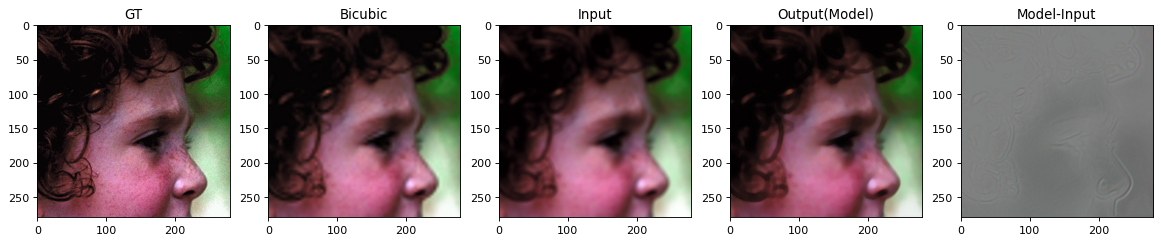

psnr for bicubic is 32.67973093611556dB
psnr for input is 31.727980012822368dB
psnr for Model is 30.95307938417697dB
PSNR improvement is -0.7749006286453977dB
Sharpness Measurement GroundTruth: 233.21159694144288
Sharpness Measurement Bicubic: 15.434929803238646
Sharpness Measurement Input: 8.727089964313272
Sharpness Measurement Model: 28.37870178955245


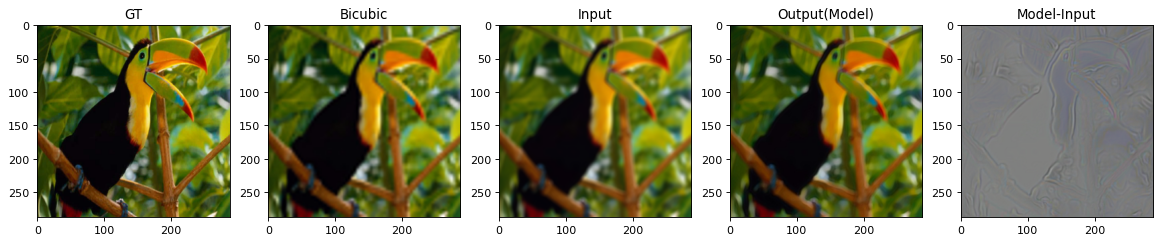

Bicubic average PSNR = 32.04782717725036
Model average PSNR = 29.505377974240822


In [56]:
test_results("/media/SSD/superres/video_data/test_data/Set5", 4, channels = 1,display = True)

psnr for bicubic is 33.390163695766894dB
psnr for input is 32.79310964459529dB
psnr for Model is 29.88098856357702dB
PSNR improvement is -2.9121210810182703dB
Sharpness Measurement GroundTruth: 247.28295878820063
Sharpness Measurement Bicubic: 9.535258178118966
Sharpness Measurement Input: 5.858893811702728
Sharpness Measurement Model: 15.241454898787197


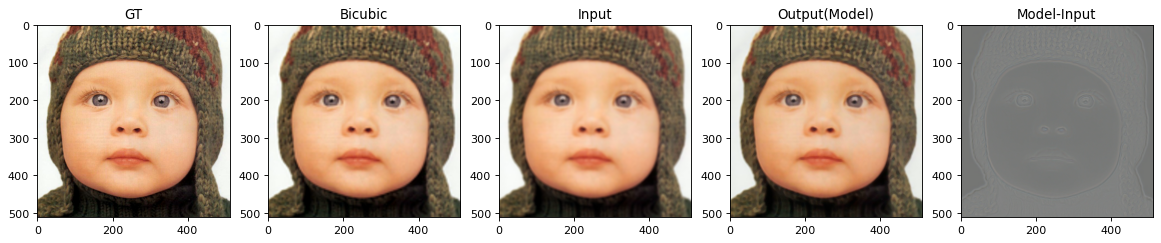

psnr for bicubic is 32.235298592507704dB
psnr for input is 31.382772027682307dB
psnr for Model is 31.685356691457486dB
PSNR improvement is 0.30258466377517834dB
Sharpness Measurement GroundTruth: 726.1960912189749
Sharpness Measurement Bicubic: 24.910532272341808
Sharpness Measurement Input: 14.338576666300607
Sharpness Measurement Model: 41.02229507129518


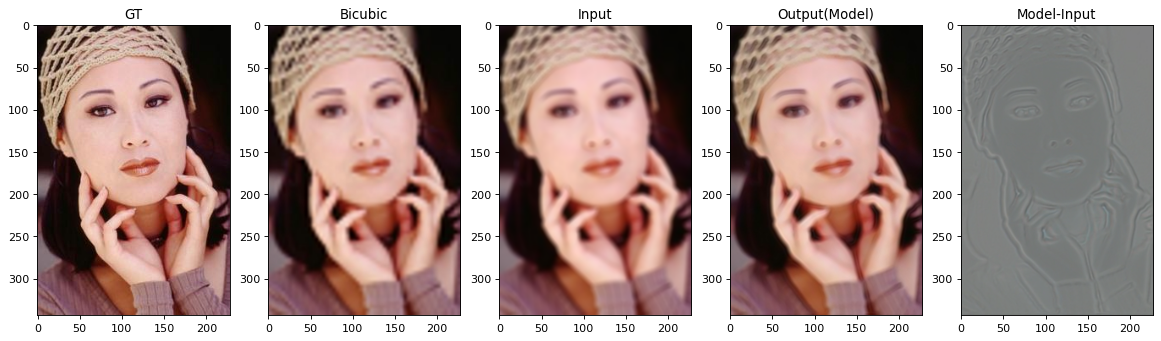

psnr for bicubic is 30.211868582917297dB
psnr for input is 28.432968257934547dB
psnr for Model is 29.01814487106245dB
PSNR improvement is 0.5851766131279028dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 68.43807946145535
Sharpness Measurement Input: 54.08266585692763
Sharpness Measurement Model: 160.30407737195492


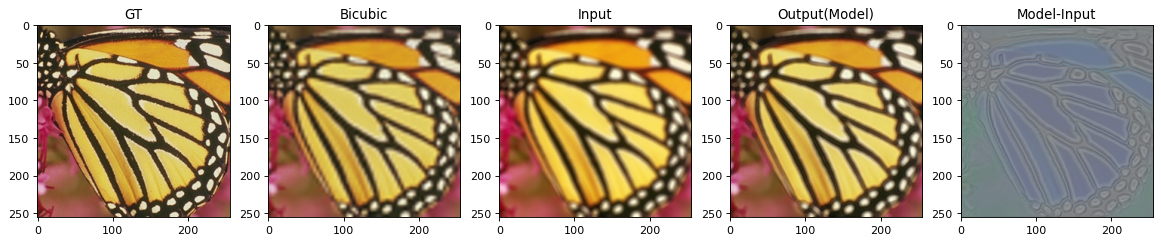

psnr for bicubic is 31.72207407894435dB
psnr for input is 31.14274836086718dB
psnr for Model is 31.045435556455963dB
PSNR improvement is -0.09731280441121726dB
Sharpness Measurement GroundTruth: 593.2631865654935
Sharpness Measurement Bicubic: 5.852487158833559
Sharpness Measurement Input: 5.359579077565338
Sharpness Measurement Model: 12.412623132125937


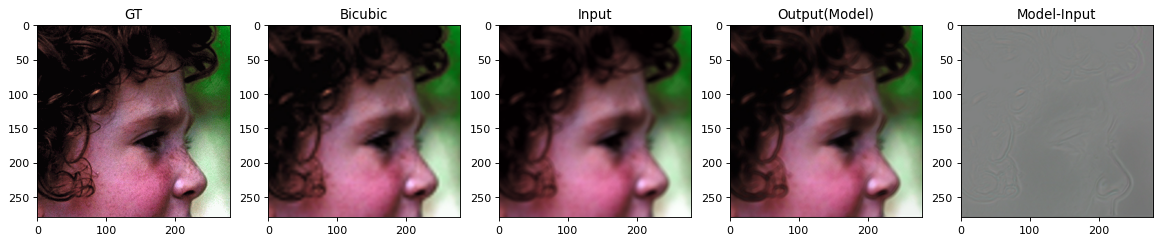

psnr for bicubic is 32.67973093611556dB
psnr for input is 31.727980012822368dB
psnr for Model is 32.206978815646956dB
PSNR improvement is 0.47899880282458795dB
Sharpness Measurement GroundTruth: 233.21159694144288
Sharpness Measurement Bicubic: 15.434929803238646
Sharpness Measurement Input: 8.727089964313272
Sharpness Measurement Model: 25.30917959804852


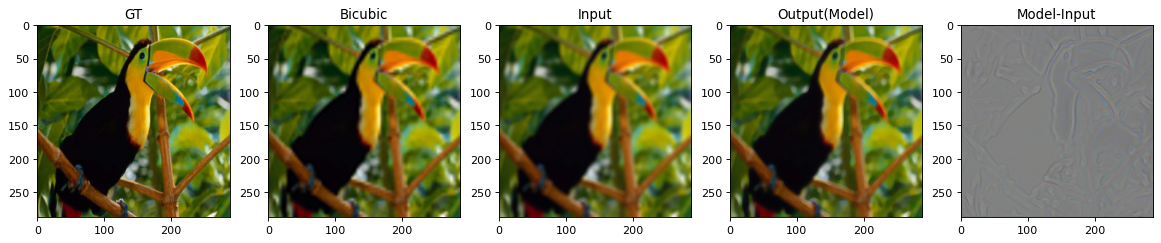

Bicubic average PSNR = 32.04782717725036
Model average PSNR = 30.76738089963997


In [96]:
test_results("/media/SSD/superres/video_data/test_data/Set5", 4, channels = 1,display = True)

# convert sample videos

In [57]:
result_path

PosixPath('/media/SSD/superres/Results/Superresolution train New Network')

In [58]:


infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-16.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=1.6,display=False,bitrate= "4000k")

  1%|          | 7/900 [00:00<00:12, 69.81it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network/muffins30sec-16.mp4
factor: 1.6 
width= 512 
height= 384 
bitrate= 4000k


100%|██████████| 900/900 [00:14<00:00, 60.11it/s]


True

In [59]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-10.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k")

  3%|▎         | 23/900 [00:00<00:03, 223.62it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network/muffins30sec-10.mp4
factor: 1.0 
width= 320 
height= 240 
bitrate= 4000k


100%|██████████| 900/900 [00:03<00:00, 226.32it/s]


True

In [60]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-20.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=2.0,display=False,bitrate= "4000k")

  1%|          | 6/900 [00:00<00:16, 55.43it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network/muffins30sec-20.mp4
factor: 2.0 
width= 640 
height= 480 
bitrate= 4000k


100%|██████████| 900/900 [00:16<00:00, 54.39it/s]


True

In [61]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-30.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=3.0,display=False,bitrate= "4000k")


  0%|          | 3/900 [00:00<00:35, 25.59it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network/muffins30sec-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k


100%|██████████| 900/900 [00:33<00:00, 26.59it/s]


True

In [62]:
dualfile= str(result_path/"muffins30sec-30dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [63]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [64]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [65]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = result_path/"super8.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/super8_best_from_mp2.mp4
frames= 7195 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train New Network/super8.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 7195/7195 [02:10<00:00, 55.08it/s]


True

In [66]:

dualfile = str(result_path/"super8dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [67]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [68]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/super8hresperfuzmodel2.mp4"
outfile = str(result_path/"super8.mp4")
dualfile= str(result_path/"super8-tolast-dual.mp4")

In [69]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [70]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = str(result_path/"super8long.mp4")
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

  0%|          | 4/121409 [00:00<59:46, 33.85it/s]

Original File: /media/SSD/superres/super8/Old 8mm Reels_1.mp4
frames= 121409 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train New Network/super8long.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 121409/121409 [35:37<00:00, 56.79it/s]


True

In [71]:
dualfile= str(result_path/"super8longdual.mp4")
infile = str(infile)
outfile = str(outfile)

In [72]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su